In [1]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, LdaSeqModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from gensim.models.wrappers.dtmmodel import DtmModel
from tqdm import tqdm
from analysis_utils import topic_diversity

/home/users/amarvenu/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('data/combined_clean.parquet')

In [3]:
df.groupby('type').text.count()

type
fomc_statement     195
speech            1455
Name: text, dtype: int64

In [4]:
split_text = df['filtered_text'].str.split().values

In [5]:
#dictionary = Dictionary(split_text)
id2word = Dictionary(split_text)
corpus = [id2word.doc2bow(text) for text in split_text]

In [6]:
id2word.save('dict_save')

In [6]:
len(id2word)

4938

## Dynamic LDA

In [7]:
time_slice = df.groupby('slice').date.count().tolist()
time_slice

[716, 546, 201, 187]

In [13]:
%%time
model = DtmModel(
    dtm_path="/home/users/amarvenu/workspace/cs224n/fed_detm/dtm-linux64", 
    corpus=corpus, 
    id2word=id2word, 
    time_slices=time_slice,
    num_topics=10,
    mode='fit',
    model='dtm',
    rng_seed=2
)

CPU times: user 950 ms, sys: 138 ms, total: 1.09 s
Wall time: 16min 40s


In [14]:
model.save('dtm_model_trained_t10_govslice')

In [17]:
coherences = []
for t in tqdm(range(4)):
    coherences.append(
        CoherenceModel(
            topics=model.dtm_coherence(t), 
            texts=split_text, 
            dictionary=id2word, 
            coherence='c_v'
        ).get_coherence()
    )
    
coherences = np.array(coherences)

  0%|          | 0/4 [00:00<?, ?it/s]/home/users/amarvenu/miniconda3/envs/nlp/lib/python3.9/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
100%|██████████| 4/4 [00:42<00:00, 10.51s/it]


In [24]:
diversities = []
for t in tqdm(range(4)):
    diversities.append(
        topic_diversity(topics=model.dtm_coherence(t))
    )
    
diversities = np.array(diversities)

  0%|          | 0/4 [00:00<?, ?it/s]/home/users/amarvenu/miniconda3/envs/nlp/lib/python3.9/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
100%|██████████| 4/4 [00:00<00:00, 548.62it/s]


In [25]:
qualities = diversities * coherences

In [26]:
qualities.mean(), qualities.std()

(0.2783073303166182, 0.005061625187473974)

In [27]:
np.savez_compressed(
    'dlda_stats.npz',
    coherence=coherences,
    diversity=diversities
)

## try to do some topic analysis

In [8]:
model = DtmModel.load('dtm_model_trained_t10_govslice')

In [9]:
for topic in model.dtm_coherence(0):
    print(topic)

['risk', 'management', 'bank', 'process', 'organization', 'control', 'internal', 'financial', 'institution', 'practice', 'information', 'credit', 'business', 'banking', 'new', 'disclosure', 'change', 'standard', 'supervisor', 'accounting']
['job', 'worker', 'work', 'economy', 'new', 'high', 'education', 'year', 'benefit', 'return', 'technology', 'people', 'good', 'system', 'government', 'percent', 'time', 'social', 'income', 'text']
['community', 'loan', 'bank', 'small', 'business', 'financial', 'credit', 'lending', 'consumer', 'development', 'institution', 'datum', 'income', 'program', 'help', 'mortgage', 'provide', 'local', 'area', 'information']
['financial', 'risk', 'asset', 'liquidity', 'credit', 'bank', 'fund', 'security', 'investor', 'system', 'term', 'institution', 'crisis', 'return', 'debt', 'participant', 'central', 'funding', 'private', 'reserve']
['policy', 'inflation', 'monetary', 'rate', 'price', 'central', 'bank', 'interest', 'economy', 'target', 'term', 'long', 'change'

/home/users/amarvenu/miniconda3/envs/nlp/lib/python3.9/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


In [36]:
def get_word_probs(word, topic, model):
    prob_list = []
    for t in range(4):
        top50 = model.show_topic(topic, t, topn=100)
        words = [x[1] for x in top50]
        probs = [x[0] for x in top50]
        prob_dict = dict(zip(words, probs))
        prob_list.append(prob_dict[word])
    return prob_list

In [53]:
get_word_probs('foreclosure', 9, model)

[0.0026821391730801167,
 0.002956780955036481,
 0.0030299277446776776,
 0.0030290798001043344]

In [61]:
plot_df = pd.DataFrame({
    'credit': get_word_probs('credit', 9, model),
    'security': get_word_probs('security', 3, model),
    'foreclosure': get_word_probs('foreclosure', 9, model),
    'subprime': get_word_probs('subprime', 9, model),
    'labor': get_word_probs('labor', 1, model),
    'technology': get_word_probs('technology', 1, model),
    #'vol': get_word_probs('vol', 3, model),
    'demand': get_word_probs('demand', 6, model),
    'regulation': get_word_probs('regulation', 7, model),
    'requirement': get_word_probs('requirement', 7, model),
    'inflation': get_word_probs('inflation', 4, model),
    'unemployment': get_word_probs('unemployment', 5, model),
    'stress': get_word_probs('stress', 7, model),
})
plot_df.to_csv('dlda_evolve.csv', index=False)

In [59]:
plot_df

,credit,security,foreclosure,subprime,labor,technology,demand,regulation,requirement,inflation,unemployment,stress
0,0.015502,0.008266,0.002682,0.002564,0.003667,0.005076,0.006338,0.007419,0.006997,0.030547,0.006195,0.005613
1,0.015327,0.008222,0.002957,0.002791,0.004547,0.004069,0.006325,0.007986,0.008352,0.026354,0.006426,0.006402
2,0.012612,0.008092,0.003030,0.002803,0.006194,0.003256,0.006124,0.008908,0.009643,0.018721,0.006638,0.007672
3,0.010633,0.008039,0.003029,0.002780,0.007219,0.002873,0.005842,0.009221,0.009370,0.015976,0.006747,0.008688


<Axes: >

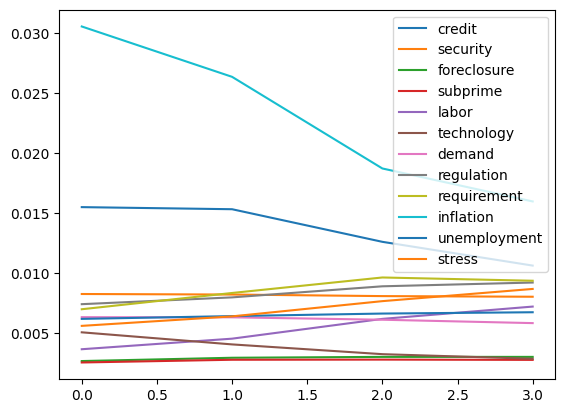

In [60]:
plot_df.plot()